# Final Project

## Feature Prototype

### Project Idea 1: Deep Learning on a public dataset



In [1]:
# Importing Tensor flow and checking that the GPU is Recognized

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# Load Data

In [ ]:
# Importing Library to load the Dataset
from scipy.io import loadmat

# Change this names !!

train_raw = loadmat('../data/mat/train_32x32.mat')  # Train Set
test_raw = loadmat('../data/mat/test_32x32.mat')    # Test Set
extra_raw = loadmat('../data/mat/extra_32x32.mat')  # Extra Set

Below, I am splitting up the dataset into training data and training labels

In [ ]:
import numpy as np

# Training Set & Labels
train_data = train_raw['X']
train_labels = train_raw['y']

# Extra Dataset & Labels
extra_data = extra_raw['X']
extra_labels = extra_raw['y']

# Test Data & Labels
test_data = test_raw['X']
test_labels = test_raw['y']

Below, I am checking the shape of each of the data and labels sets.

In [659]:
print('Training Data:', train_data.shape, 'Training Labels:', train_labels.shape)
print('Extra Data:', extra_data.shape, 'Extra Lables:', extra_labels.shape)
print('Test Data:', test_data.shape, 'Test Lables:', test_labels.shape)


Training Data: (32, 32, 3, 73257) Training Labels: (73257, 1)
Extra Data: (32, 32, 3, 531131) Extra Lables: (531131, 1)
Test Data: (32, 32, 3, 26032) Test Lables: (26032, 1)


# Exploratory Analysis

Below, A function to plot the training image samples.

In [712]:
# Adapted From https://www.tensorflow.org/tutorials/load_data/images

# Import the matplotlib library for visualization
import matplotlib.pyplot as plt

def plot_sample_images(data, labels):

    # Create a new figure with a specific size of 10x10
    plt.figure(figsize=(10, 10))

    # Loop over the first 9 images in the dataset
    for i in range(9):
        
        # Create a subplot in a 3x3 grid
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the i-th image from the 'train_data'    
        plt.imshow(data[:, :, :, i])
        
        # Set the title of the subplot to the corresponding label in 'train_labels'
        plt.title(labels[i])
        
        # Turn off the axis to remove ticks and labels for a cleaner display
        plt.axis("off")


Here are the first nine images from the training dataset.

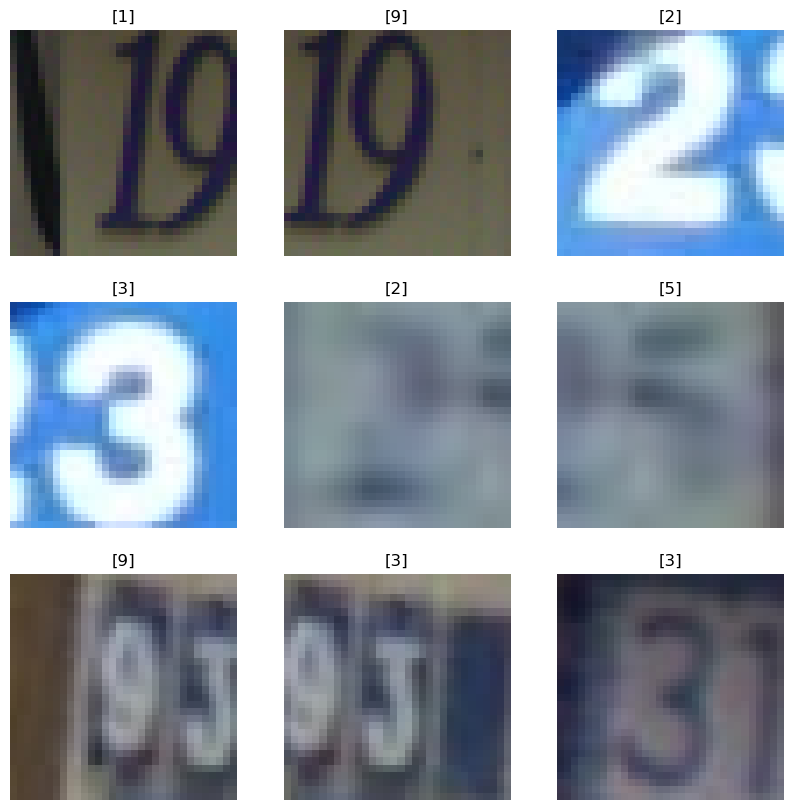

In [714]:
plot_sample_images(train_data, train_labels)

You can see that the 32 x 32 images contain distracting numbers to the side making it a real-world issue to solve.

Below, I am creating a function to display the distribution of the labels in the datasets.

In [708]:
import numpy as np
import seaborn as sns

def label_count_plot(labels, x_axis, y_axis, title, axis=None):
    """
    Creates a bar plot to visualize the count of unique labels in a dataset.

    Parameters:
    -----------
    labels : array-like
        A list, array, or similar structure containing categorical data.
    x_axis : str
        The label for the x-axis of the plot.
    y_axis : str
        The label for the y-axis of the plot.
    title : str
        The title of the bar plot.

    Returns: None
    --------
    """

    # Get unique labels and their counts from the input data
    unqique, counts = np.unique(labels, return_counts=True)

    # Combine the unique labels and their counts into a dictionary
    dict_counts =  dict(zip(unqique, counts))

    # Create a bar plot using Seaborn
    # x-axis: unique labels
    # y-axis: counts of each label
    # Set the axis labels and title of the plot
    sns.barplot(dict_counts, x=dict_counts.keys(), y= dict_counts.values(),
                 ax=axis).set(xlabel=x_axis, ylabel=y_axis, title=title) 


Plotting the datasets Label distributions.

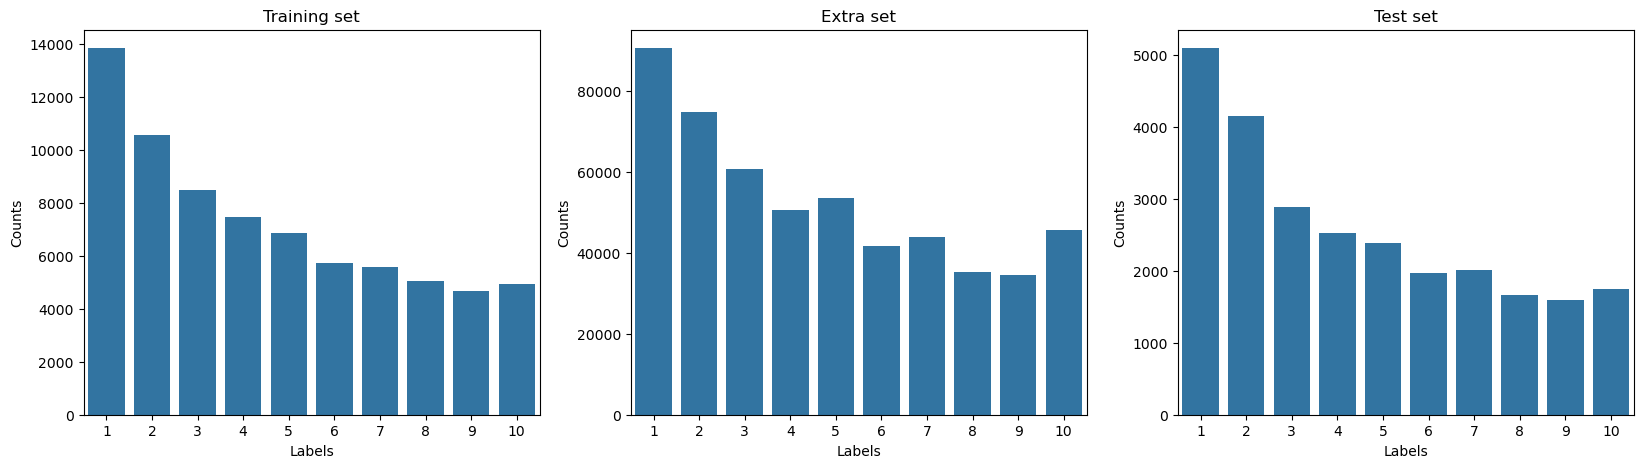

In [709]:
# Create a subplot in a 3x3 grid
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
label_count_plot(train_labels, "Labels", "Counts", "Training set", axis=ax[0])
label_count_plot(extra_labels, "Labels", "Counts", "Extra set", axis=ax[1])
label_count_plot(test_labels, "Labels", "Counts", "Test set", axis=ax[2])

You can see from the plots above that the data is imbalanced. I will have to address this imbalance in order to create an accurate model. All the dataset have more or less the same distribution imbalances.

# Pre-Processing

Here I will pre-process the dataset for training. I will be using the same method as ( Sermanet, Pierre, Chintala, Soumith, and LeCun, Yann ) in their paper 'Convolutional neural networks applied to house numbers digit classification'. 

In [710]:
# Function to create a validation set

def create_validation_set(X, y, num_samples_per_class):

    # Array: Stores the unique classes of label set
    unique_classes = np.unique(y)

    # List: To store chosen indexes                   
    chosen_indexes = []                             
    
    # Loop: iterate through each class
    for cls in unique_classes:                      

        # Array: Store all indexes from a class
        class_indexes = np.where(y == cls)[0]       

        # Array: Randomly select n indices from 'class_indexes'
        chosen_class_indexes = np.random.choice(class_indexes, num_samples_per_class, replace=False)
        # List:  Add each class indices to a list
        chosen_indexes.extend(chosen_class_indexes)

    # Array: Convert list to Numpy Array
    chosen_indexes = np.array(chosen_indexes)

    # Array:  Return the selected samples, label and indexes
    return X[:, :, :, chosen_indexes], y[chosen_indexes], chosen_indexes


## Validation Set
To build a validation set, we select 400 samples per class from the training set and 200 samples per class from the extra set. The remaining digits of the train and extra sets are used for training.

In [711]:
# Creating Validation Function

# Choose 400 samples from the training set for each class.
X_val_train, y_val_train, val_train_indexes = create_validation_set(train_data, train_labels, 400)

# Choose 200 samples from the extra set for each class.
X_val_extra, y_val_extra, val_extra_indexes = create_validation_set(extra_data, extra_labels, 200)

# Merge the two sets' validation samples.
X_val = np.concatenate((X_val_train, X_val_extra), axis=3)  # Combine along the 4th dimension
y_val = np.concatenate((y_val_train, y_val_extra), axis=0)

print('Validation data:', X_val.shape ,'Validation Labels:', y_val.shape)



Validation data: (32, 32, 3, 6000) Validation Labels: (6000, 1)


There are 6000 samples in the dataset.

Below, I am plotting the distribution of the validation set.

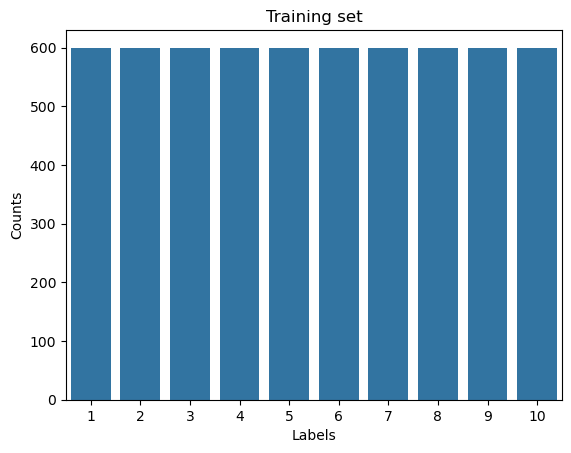

In [705]:
label_count_plot(y_val, "Labels", "Counts", "Training set")

The validation set has an equal distribution.

A function to Shuffle the datasets

In [725]:
def shuffle_dataset(data, labels):

    # Create a random number generator with a fixed seed
    seed = 42
    rng = np.random.default_rng(seed)

    # Generate indexes for the validation set
    shuffle_indexes = np.arange(labels.shape[0])  # Create an array of indexes
    rng.shuffle(shuffle_indexes)  # Shuffle the indexes in-place

    # Reorder X_val and y_val using the shuffled indexes
    shuffled_data = data[:, :, :, shuffle_indexes]
    shuffled_labels = labels[shuffle_indexes]

    return shuffled_data, shuffled_labels

Shuffling the Validation set

In [730]:
X_val, y_val = shuffle_dataset(X_val, y_val)

Plotting 9 sample from the validation set.

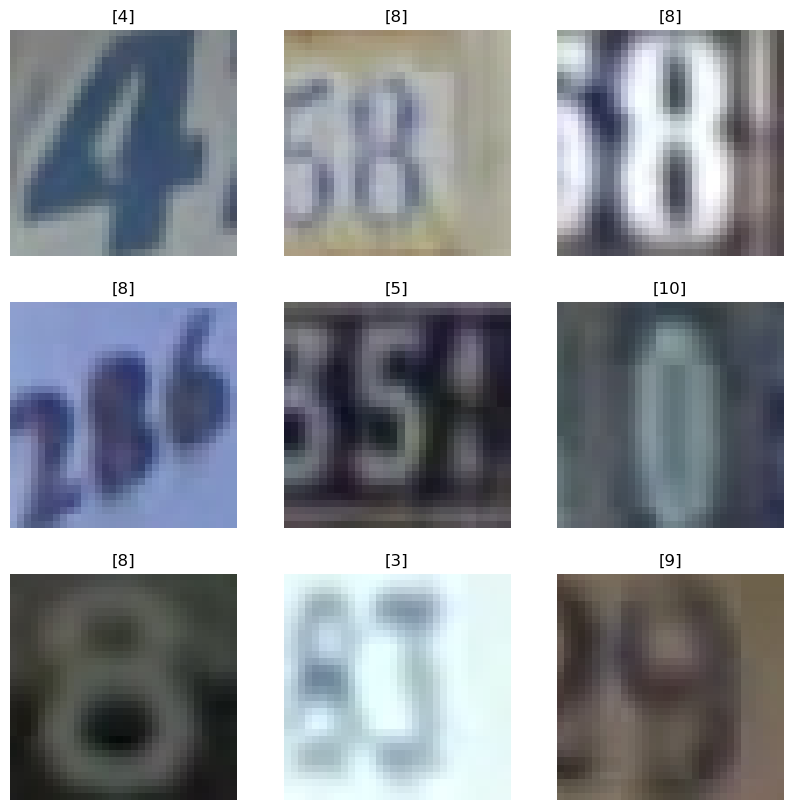

In [731]:
plot_sample_images(X_val, y_val)

## Training Set

Below, I will now remove the validation samples from the training and datasets.

In [722]:
# Remove validation samples from the original training set
X_train_new = np.delete(train_data, val_train_indexes, axis=3)
y_train_new = np.delete(train_labels, val_train_indexes, axis=0)

X_extra_new = np.delete(extra_data, val_extra_indexes, axis=3)
y_extra_new = np.delete(extra_labels, val_extra_indexes, axis=0)

# CHECK IF YOU NEED TO CONCATENATE THESE DATASETS!!!


print('===================================================================')
print('Original Shape')
print('Training Data:', train_data.shape, 'Training Labels:', train_labels.shape)
print('Extra Data:', extra_data.shape, 'Extra Lables:', extra_labels.shape)
print('===================================================================')
print('New Shape')
print('Training Data:', X_train_new.shape, 'Training Labels:', y_train_new.shape)
print('Extra Data:', X_extra_new.shape, 'Extra Lables:', y_extra_new.shape)

Original Shape
Training Data: (32, 32, 3, 73257) Training Labels: (73257, 1)
Extra Data: (32, 32, 3, 531131) Extra Lables: (531131, 1)
New Shape
Training Data: (32, 32, 3, 69257) Training Labels: (69257, 1)
Extra Data: (32, 32, 3, 529131) Extra Lables: (529131, 1)


Above, You can see the new datasets size after removing the validation samples

Below, I will now merge the training set and extra set together to create 1 training set.

In [723]:
# Merge the two sets' training data samples.
X_train_merge = np.concatenate((X_train_new, X_extra_new), axis=3)  # Combine along the 4th dimension
y_train_merge = np.concatenate((y_train_new, y_extra_new), axis=0)

print('New training set Data:', X_train_merge.shape, 'New Training set Labels:', y_train_merge.shape)

New training set Data: (32, 32, 3, 598388) New Training set Labels: (598388, 1)


Above, You can see there are now just under 600,00 samples

Shuffling the Merged data set

In [733]:
X_train_merge, y_train_merge = shuffle_dataset(X_train_merge, y_train_merge)

Plotting the new merged dataset samples.

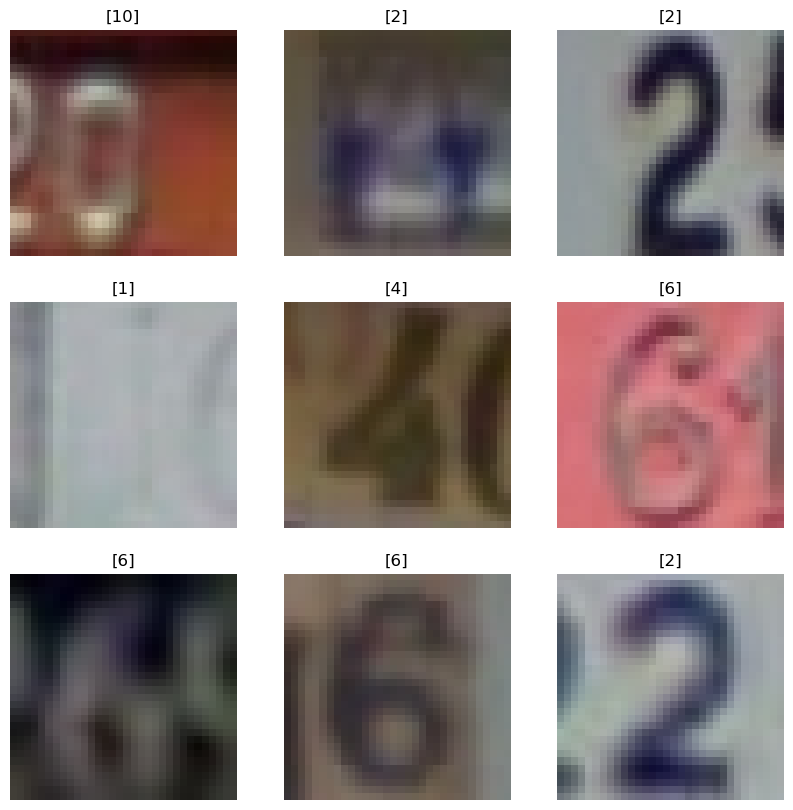

In [734]:
plot_sample_images(X_train_merge, y_train_merge)

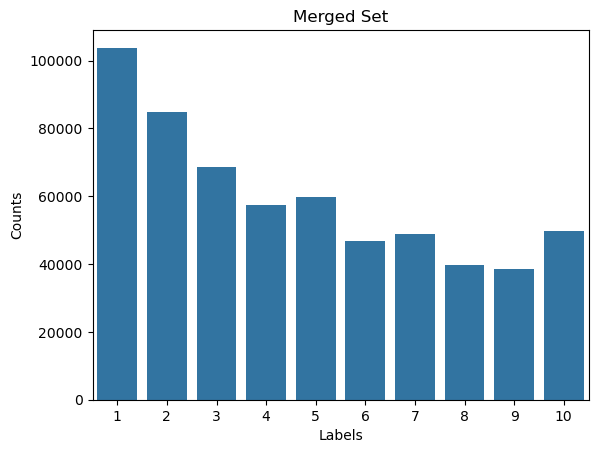

In [736]:
label_count_plot(y_train_merge, "Labels", "Counts", "Merged Set")

## Converting data types and Reshaping

Below, I am converting the training set to float32 and the label set to int32 for better compatibility with the Keras model.

In [737]:
# Convert sets to float32
X_train_float = X_train_merge.astype('float32')     # Training Set Data
X_val_float = X_val.astype('float32')               # Validation Set Data
test_data_float  = test_data.astype('float32')      # Test set Data

y_train_merge = y_train_merge.astype('int32')       # Train set Labels
y_val = y_val.astype('int32')                       # Validation set labels


Below, I am reshaping the data to better match the Tensorflow/Keras standard of (batch_size, height, width, depth)

In [739]:
#Reshape

X_train_reshaped = np.transpose(X_train_float, (3, 0, 1, 2))        # Shape: (32, 32, 3, 598388)
X_val_reshaped = np.transpose(X_val_float, (3, 0, 1, 2))            # Shape: (32, 32, 3, 6000)
test_data_reshaped = np.transpose(test_data_float, (3, 0, 1, 2))    # Shape: (32, 32, 3, 26032)


print("Training data", X_train_reshaped.shape, "Training Labels", y_train_merge.shape )
print("Validation data", X_val_reshaped.shape, "598388, 32, 32, Validation Labels", y_val.shape )
print("Test data", test_data_reshaped.shape, "Test Labels", test_labels.shape)

X_train_reshape data (598388, 32, 32, 3) y_train_merge Labels (598388, 1)
X_train_reshape data (6000, 32, 32, 3) y_train_merge Labels (6000, 1)
X_train_reshape data (26032, 32, 32, 3) y_train_merge Labels (26032, 1)


## Normalization

Normalize the data to a common scale for more efficient training.

In [ ]:
# Create the Normalization object
norm_layer = tf.keras.layers.Normalization(axis=-1)

# Fit the training data to calcualte the mena and Variance
norm_layer.adapt(X_train_reshaped)

In [619]:
print("Mean:", norm_layer.mean.numpy())  # Should output the computed mean
print("Variance:", norm_layer.variance.numpy())  # Should output the computed variance

Mean: [[[[109.87048  109.691414 113.77533 ]]]]
Variance: [[[[2511.731  2557.4302 2586.5073]]]]


Apply normalization to the training and validation sets.

In [ ]:
# Normalise Data

with tf.device('/CPU:0'):
    X_train_normalized = norm_layer(X_train_reshaped)
    X_val_normalized = norm_layer(X_val_reshaped)

In [620]:
# Single IMage


# Select one image (e.g., the first image)
single_image = X_train_reshaped[0, :, :, :]  # Shape: (32, 32, 3)

# Assuming single_image has shape (32, 32, 3)
single_image_batch = tf.expand_dims(single_image, axis=0)  # Shape: (32, 32, 3, 1)

# Normalize the single image
normalized_image = norm_layer(single_image_batch)  # Shape: (32, 32, 3)


In [621]:
print("Normalized Image Mean:", tf.reduce_mean(normalized_image).numpy())  # Should be close to 0
print("Normalized Image Std Dev:", tf.math.reduce_std(normalized_image).numpy())  # Should be close to 1

Normalized Image Mean: -0.9414976
Normalized Image Std Dev: 0.501524


In [622]:
single_image_batch.shape

TensorShape([1, 32, 32, 3])

In [623]:
normalized_image[0, :, :, :]

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[-1.5338153 , -1.5758309 , -1.4899476 ],
        [-1.8929735 , -1.7142501 , -1.8635389 ],
        [-1.8929735 , -1.8328952 , -1.8635389 ],
        ...,
        [-0.7556389 , -0.8837353 , -1.136019  ],
        [-0.55610645, -0.64644533, -1.1163563 ],
        [-0.41643378, -0.606897  , -1.0770309 ]],

       [[-1.6335815 , -1.3978635 , -1.5489357 ],
        [-1.9129268 , -1.6747018 , -1.8045508 ],
        [-1.9129268 , -1.7735726 , -1.9028642 ],
        ...,
        [-1.3941426 , -1.3978635 , -1.2539952 ],
        [-0.8554051 , -1.0221545 , -1.2146698 ],
        [-0.5361532 , -0.6266712 , -1.0573682 ]],

       [[-1.3941426 , -1.3583152 , -1.4899476 ],
        [-1.8331139 , -1.7537985 , -1.7258999 ],
        [-1.8730203 , -1.8328952 , -1.784888  ],
        ...,
        [-1.7333477 , -1.5956051 , -1.3523086 ],
        [-1.4939088 , -1.338541  , -1.3719714 ],
        [-0.7556389 , -0.8046386 , -1.1950071 ]],

       ...,

       

In [624]:
# Flip test

flip_test = np.flip(normalized_image[0, :, :, :], axis=(0,1))
# flip_test = np.flip(normalized_image[0, :, :, :], axis=(0,1))
# flip_test = np.flipud(normalized_image[0, :, :, :])
# flip_test = np.fliplr(normalized_image[0, :, :, :])

In [625]:
# Flip Test
from scipy import  ndimage

flip_test = ndimage.zoom(flip_test, (2,2,1))

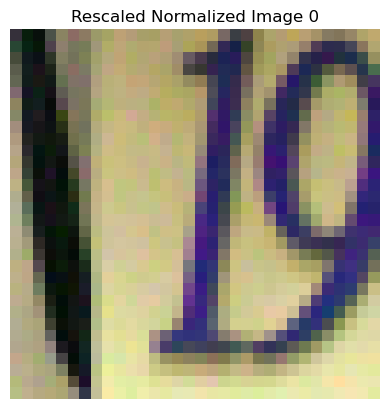

In [626]:
# Show normalized Image

import matplotlib.pyplot as plt

# Rescale to [0, 1]
# https://stackoverflow.com/questions/1456000/rescaling-ranges
rescaled_image = (normalized_image[0, :, :, :] - tf.reduce_min(normalized_image[0, :, :, :])) / (tf.reduce_max(normalized_image[0, :, :, :]) - tf.reduce_min(normalized_image[0, :, :, :]))
# rescaled_image = (flip_test - tf.reduce_min(flip_test)) / (tf.reduce_max(flip_test) - tf.reduce_min(flip_test))

# Display the rescaled image
plt.imshow(rescaled_image.numpy())  # Use .numpy() if working with a TensorFlow tensor
plt.title(f"Rescaled Normalized Image {i}")
plt.axis('off')
plt.show()

## Common Baseline Model

Since I know my data distribution is imbalanced I will calculate the sample weight for each class to get a accurate accuracy score for my baseline.

In [749]:
# Imbalanced Dataset Compute Class Weights
# https://www.geeksforgeeks.org/how-to-handle-class-imbalance-in-tensorflow/

from sklearn.utils import class_weight


# Reshape the labels for sample_weights
y_flat_cw = y_train_merge.flatten()

# calculate the sample weights
sp_weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_flat_cw)

# Create a dictionary with the Sampple weights results
sample_weights = dict(enumerate(sp_weights))

# Class weight for tensor flow
# cl_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_flat_cw), y=y_flat_cw)
# class_weights = dict(enumerate(cl_weights))


Below, I need to convert the dictionary values to a numpy array so they can be processed by the dummy classier.

In [750]:
# class_weights_array = np.array(list(class_weights.values()))
# class_weights_array

# Convert the dictionary to a numpy array
sample_weights_array = np.array(list(sample_weights.values()))
sample_weights_array

array([1.19922241, 0.70627088, 0.70627088, ..., 0.57636509, 0.87149806,
       0.70627088])

Below, I need to flatten the training data so it can be used with the dummy classier.

In [751]:
# Reshaping for Dummy Classifier
# Let numpy figure out the shape automatically with -1

# Reshape the image data to (n_samples, n_features)
X_train_flattened = X_train_merge.reshape(X_train_merge.shape[3], -1)   # Shape: (598388, 32, 32, 3)
X_val_flattened = X_val.reshape(X_val.shape[3], -1)                     # Shape: (6000, 32, 32, 3)

print('Flattened Training data:', X_train_flattened.shape, 'Flattened Validation Data:', X_val_flattened.shape )

Flattened Training data: (598388, 3072) Flattened Validation Data: (6000, 3072)


Running the dummy classifier on the Training data and evaluating on the validation set. Calculating the accuracy

In [752]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Fit the dummy

# Initialize and fit DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)

dummy_clf.fit(X_train_flattened, y_train_merge, sample_weight=sample_weights_array)


# Get predictions on the validation set
y_pred = dummy_clf.predict(X_val_flattened)

# Evaluate accuracy
baseline_accuracy = accuracy_score(y_val, y_pred)
print(f"Baseline Accuracy (Stratified): {baseline_accuracy * 100:.2f}%")

Baseline Accuracy (Stratified): 10.47%


The accuracy is currently around 10%, which is expected for a random guess in a balanced dataset with 10 classes (digits 0–9). I applied a sample weight dictionary to the model to assign higher weights to the underrepresented labels, ensuring that the model pays more attention to them during training. To demonstrate that the machine learning model is learning patterns in the data and achieving statistical accuracy, I would expect it to perform significantly better than 10% accuracy

In [37]:
# NOT NEEDED ?

# import tensorflow as tf
# import numpy as np

# def maxout(inputs, num_units, axis=None):
#     shape = inputs.shape.as_list()
#     if axis is None:
#         axis = -1
#     num_channels = shape[axis]
#     if num_channels % num_units:
#         raise ValueError('number of features({}) is not a multiple of num_units({})'
#              .format(num_channels, num_units))
#     shape[axis] = -1
#     shape += [num_channels // num_units]
#     outputs = tf.reduce_max(tf.reshape(inputs, shape), axis=-1, keepdims=False)
#     return outputs



In [ ]:
# # Normalise Data

# with tf.device('/CPU:0'):
#     X_train_normalized = norm_layer(X_train_reshaped)
#     X_val_normalized = norm_layer(X_val_reshaped)
# X_test_normalized = norm_layer(X_test_reshaped)

In [ ]:
# X_train_normalized

<tf.Tensor: shape=(598388, 32, 32, 3), dtype=float32, numpy=
array([[[[-1.53381526e+00, -1.57583094e+00, -1.48994756e+00],
         [-1.89297354e+00, -1.71425009e+00, -1.86353886e+00],
         [-1.89297354e+00, -1.83289516e+00, -1.86353886e+00],
         ...,
         [-7.55638897e-01, -8.83735299e-01, -1.13601899e+00],
         [-5.56106448e-01, -6.46445334e-01, -1.11635625e+00],
         [-4.16433781e-01, -6.06896996e-01, -1.07703090e+00]],

        [[-1.63358152e+00, -1.39786351e+00, -1.54893565e+00],
         [-1.91292679e+00, -1.67470181e+00, -1.80455077e+00],
         [-1.91292679e+00, -1.77357256e+00, -1.90286422e+00],
         ...,
         [-1.39414263e+00, -1.39786351e+00, -1.25399518e+00],
         [-8.55405092e-01, -1.02215445e+00, -1.21466982e+00],
         [-5.36153197e-01, -6.26671195e-01, -1.05736816e+00]],

        [[-1.39414263e+00, -1.35831523e+00, -1.48994756e+00],
         [-1.83311391e+00, -1.75379848e+00, -1.72589993e+00],
         [-1.87302029e+00, -1.83289516e

In [56]:
y_train_flatten = y_train_merge.flatten()
y_val_flatten = y_val.flatten()


print("y_train_flatten", y_train_flatten.shape, "y_val_flatten", y_val_flatten.shape )

y_train_flatten (598388,) y_val_flatten (6000,)


In [549]:
y_train_merge.shape

(598388, 1)

In [57]:
# Convert 10 to 0

import numpy as np

# Replace label 10 with 0
y_train_flatten = np.where(y_train_flatten == 10, 0, y_train_flatten)
y_val_flatten = np.where(y_val_flatten == 10, 0, y_val_flatten)

# Validate the labels
print("Unique values in adjusted y_train_flatten:", set(y_train_flatten))
print("Unique values in adjusted y_val_flatten:", set(y_val_flatten))

Unique values in adjusted y_train_flatten: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Unique values in adjusted y_val_flatten: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [548]:
y_train_flatten.shape

(598388,)

In [754]:
y_integers.shape

(598388,)

In [586]:
from sklearn.preprocessing import OneHotEncoder

# Fit the OneHotEncoder
enc = OneHotEncoder().fit(y_train_merge)

# Transform the label values to a one-hot-encoding scheme
y_train_oh = enc.transform(y_train_merge).toarray()
y_val_oh = enc.transform(y_val).toarray()

In [ ]:
# Reference: https://stackoverflow.com/questions/43481490/keras-class-weights-class-weight-for-one-hot-encoding

y_integers = np.argmax(y_train_oh, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 0.5763650899143719,
 1: 0.7062708763647093,
 2: 0.8714980629751536,
 3: 1.0408376963350785,
 4: 1.0011175801378571,
 5: 1.2810978612258879,
 6: 1.2213994121489222,
 7: 1.5033741175288295,
 8: 1.5536492275736726,
 9: 1.1992224137239968}

In [555]:
# Class weight for tensor flow
cl_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_flatten), y=y_train_flatten)
class_weights = dict(enumerate(cl_weights))
class_weights

{0: 1.1992224137239968,
 1: 0.5763650899143719,
 2: 0.7062708763647093,
 3: 0.8714980629751536,
 4: 1.0408376963350785,
 5: 1.0011175801378571,
 6: 1.2810978612258879,
 7: 1.2213994121489222,
 8: 1.5033741175288295,
 9: 1.5536492275736726}

In [58]:
# import tensorflow as tf
# import tensorflow_addons as tfa

# # Build the model
# model = tf.keras.Sequential([
#     tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),                 # Convolutional layer
#     # tf.keras.layers.Dropout(.2),              # MaxPooling layer
#     # tfa.layers.Maxout(num_units=16),                   # Maxout layer
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Print the summary
# model.summary()

In [59]:
# with tf.device('/cpu:0'):
#     history = model.fit(
#         X_train_reshaped, y_train_flatten,                # Training data and labels
#         validation_data=(X_val_reshaped, y_val_flatten),  # Validation data and labels
#         batch_size=16,                   # Number of samples per batch
#         epochs=10,                       # Number of epochs
#         verbose=1                        # Verbosity mode (1 for progress bar)
#     )

In [60]:
# from keras.preprocessing.image import ImageDataGenerator
# from keras.utils import array_to_img, img_to_array, load_img

# ImageDataGenerator.fl

In [403]:
#OLD

import tensorflow as tf
import tensorflow_addons as tfa

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
    
    tf.keras.layers.Conv2D(32, (3, 3)),                 # Convolutional layer
    tfa.layers.Maxout(num_units=2),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3)),                 # Convolutional layer
    tfa.layers.Maxout(num_units=2),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3)),                 # Convolutional layer
    tfa.layers.Maxout(num_units=2),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),    
    tfa.layers.Maxout(num_units=2),

    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 maxout (Maxout)             (None, 30, 30, 2)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        1216      
                                                                 
 maxout_1 (Maxout)           (None, 13, 13, 2)         0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 2)          0         
 2D)                                                    

In [418]:
history = model.fit(
    X_train_reshaped, y_train_flatten,                # Training data and labels
    validation_data=(X_val_reshaped, y_val_flatten),  # Validation data and labels
    batch_size=128,                   # Number of samples per batch
    epochs=30,                       # Number of epochs
    class_weight=class_weights,
    verbose=1                        # Verbosity mode (1 for progress bar)
)

Epoch 1/30
4675/4675 [==============================] - 18s 4ms/step - loss: 1.9633 - accuracy: 0.2885 - val_loss: 1.7801 - val_accuracy: 0.3617
Epoch 2/30
4675/4675 [==============================] - 16s 3ms/step - loss: 1.5305 - accuracy: 0.4583 - val_loss: 1.5785 - val_accuracy: 0.4410
Epoch 3/30
4675/4675 [==============================] - 16s 3ms/step - loss: 1.3770 - accuracy: 0.5256 - val_loss: 1.4876 - val_accuracy: 0.4823
Epoch 4/30
4675/4675 [==============================] - 17s 4ms/step - loss: 1.3231 - accuracy: 0.5548 - val_loss: 1.4342 - val_accuracy: 0.5267
Epoch 5/30
4675/4675 [==============================] - 17s 4ms/step - loss: 1.2952 - accuracy: 0.5705 - val_loss: 1.4131 - val_accuracy: 0.5353
Epoch 6/30
4675/4675 [==============================] - 16s 3ms/step - loss: 1.2517 - accuracy: 0.5915 - val_loss: 1.3943 - val_accuracy: 0.5450
Epoch 7/30
4675/4675 [==============================] - 16s 3ms/step - loss: 1.2156 - accuracy: 0.6109 - val_loss: 1.3637 - val_ac

In [433]:
#OLD

import tensorflow as tf
import tensorflow_addons as tfa

# Build the model
model_2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tfa.layers.Maxout(num_units=2),



    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tfa.layers.Maxout(num_units=2),




    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tfa.layers.Maxout(num_units=2),

    
    tf.keras.layers.Conv2D(256, (3, 3), padding='same'), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tfa.layers.Maxout(num_units=2),



    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),    
    tfa.layers.Maxout(num_units=2),


    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 maxout (Maxout)             (None, 16, 16, 2)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        1216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 maxout_1 (Maxout)           (None, 8, 8, 2)           0

In [440]:
history = model_2.fit(
    X_train_reshaped, y_train_flatten,                # Training data and labels
    validation_data=(X_val_reshaped, y_val_flatten),  # Validation data and labels
    batch_size=128,                   # Number of samples per batch
    epochs=30,                       # Number of epochs
    class_weight=class_weights,
    verbose=1                        # Verbosity mode (1 for progress bar)
)

Epoch 1/30
4675/4675 [==============================] - 20s 4ms/step - loss: 1.7282 - accuracy: 0.3935 - val_loss: 1.6032 - val_accuracy: 0.4115
Epoch 2/30
4675/4675 [==============================] - 20s 4ms/step - loss: 1.3672 - accuracy: 0.5112 - val_loss: 1.4295 - val_accuracy: 0.4668
Epoch 3/30
4675/4675 [==============================] - 20s 4ms/step - loss: 1.2497 - accuracy: 0.5602 - val_loss: 1.3454 - val_accuracy: 0.5142
Epoch 4/30
4675/4675 [==============================] - 19s 4ms/step - loss: 1.1895 - accuracy: 0.5933 - val_loss: 1.3110 - val_accuracy: 0.5393
Epoch 5/30
4675/4675 [==============================] - 19s 4ms/step - loss: 1.1511 - accuracy: 0.6159 - val_loss: 1.2715 - val_accuracy: 0.5682
Epoch 6/30
4675/4675 [==============================] - 19s 4ms/step - loss: 1.1194 - accuracy: 0.6355 - val_loss: 1.2730 - val_accuracy: 0.5788
Epoch 7/30
4675/4675 [==============================] - 19s 4ms/step - loss: 1.0961 - accuracy: 0.6479 - val_loss: 1.2447 - val_ac

In [652]:
#OLD

import tensorflow as tf
import tensorflow_addons as tfa

# Build the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
  

    tf.keras.layers.Conv2D(32, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=2),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(64, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=2),                  # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)),
    

    tf.keras.layers.Conv2D(128, (3, 3)),                 # Convolutional layer
    tf.keras.layers.Dropout(0.2),
    tfa.layers.Maxout(num_units=2),                   # Maxout layer
    tf.keras.layers.MaxPooling2D((2, 2)), 
       

    tf.keras.layers.Flatten(),

    
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(0.5),    
    tfa.layers.Maxout(num_units=2),
    

    tf.keras.layers.Dense(10, activation='softmax')    # Output layer for 10 classes
])

# Compile the model
model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 dropout_12 (Dropout)        (None, 30, 30, 32)        0         
                                                                 
 maxout_12 (Maxout)          (None, 30, 30, 2)         0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 2)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        1216      
                                                                 
 dropout_13 (Dropout)        (None, 13, 13, 64)        0         
                                                      

In [653]:
history = model_3.fit(
    X_train_normalized, y_train_oh,                # Training data and labels
    validation_data=(X_val_normalized, y_val_oh),  # Validation data and labels
    batch_size=128,                   # Number of samples per batch
    epochs=100,                       # Number of epochs
    class_weight=d_class_weights,
    verbose=1                        # Verbosity mode (1 for progress bar)
)

Epoch 1/100
4675/4675 [==============================] - 21s 4ms/step - loss: 1.7088 - accuracy: 0.3829 - val_loss: 2.3832 - val_accuracy: 0.1348
Epoch 2/100
4675/4675 [==============================] - 20s 4ms/step - loss: 1.4849 - accuracy: 0.4639 - val_loss: 2.6468 - val_accuracy: 0.1172
Epoch 3/100
4675/4675 [==============================] - 21s 4ms/step - loss: 1.4238 - accuracy: 0.4963 - val_loss: 2.7774 - val_accuracy: 0.1482
Epoch 4/100
4675/4675 [==============================] - 21s 4ms/step - loss: 1.3738 - accuracy: 0.5248 - val_loss: 2.8421 - val_accuracy: 0.1543
Epoch 5/100
4675/4675 [==============================] - 21s 4ms/step - loss: 1.3405 - accuracy: 0.5422 - val_loss: 2.8918 - val_accuracy: 0.1632
Epoch 6/100
4675/4675 [==============================] - 21s 4ms/step - loss: 1.3192 - accuracy: 0.5522 - val_loss: 2.9278 - val_accuracy: 0.1630
Epoch 7/100
4675/4675 [==============================] - 21s 4ms/step - loss: 1.3074 - accuracy: 0.5589 - val_loss: 2.9033 -

KeyboardInterrupt: 

In [396]:
# New
# model_07/12_12:00_epochs

import tensorflow as tf
import tensorflow_addons as tfa
from keras.constraints import max_norm
from keras.optimizers import Adam

# Build the model
model_4 = tf.keras.Sequential([

    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
    tf.keras.layers.Dropout(.1),              

    tf.keras.layers.Conv2D(96, (5, 5), strides=(1, 1), padding="same", kernel_constraint=max_norm(4)),                              
    tfa.layers.Maxout(num_units=2),                   
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(.25),

    tf.keras.layers.Conv2D(128, (5, 5), strides=(1, 1), padding="same" , kernel_constraint=max_norm(4)),              
    tfa.layers.Maxout(num_units=2),                   #
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(.25), 

    tf.keras.layers.Conv2D(256, (5, 5), strides=(1, 1), padding="same" , kernel_constraint=max_norm(4)),              
    tfa.layers.Maxout(num_units=2),                   
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(.5),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,kernel_constraint=max_norm(4)),
    tf.keras.layers.Dropout(.5),
    tfa.layers.Maxout(num_units=2),

    tf.keras.layers.Dense(10, activation='softmax', kernel_constraint=max_norm(4))    # Output layer for 10 classes
])

# Compile the model
optimizer = Adam(beta_1=0.95)
model_4.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_5 (Dropout)         (None, 32, 32, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 96)        7296      
                                                                 
 maxout_4 (Maxout)           (None, 32, 32, 2)         0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 2)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 15, 15, 2)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 15, 15, 128)       6528      
                                                      

In [402]:
history = model_4.fit(
    X_train_reshaped, y_train_flatten,                # Training data and labels
    validation_data=(X_val_reshaped, y_val_flatten),  # Validation data and labels
    batch_size=256,                   # Number of samples per batch
    epochs=30,                       # Number of epochs
    class_weight=class_weights,
    verbose=1                        # Verbosity mode (1 for progress bar)
)

Epoch 1/30
2338/2338 [==============================] - 34s 15ms/step - loss: 2.1548 - accuracy: 0.1840 - val_loss: 2.0478 - val_accuracy: 0.2095
Epoch 2/30
2338/2338 [==============================] - 34s 15ms/step - loss: 1.9076 - accuracy: 0.2768 - val_loss: 2.0699 - val_accuracy: 0.2380
Epoch 3/30
2338/2338 [==============================] - 34s 14ms/step - loss: 1.8385 - accuracy: 0.2997 - val_loss: 2.0371 - val_accuracy: 0.2525
Epoch 4/30
2338/2338 [==============================] - 34s 14ms/step - loss: 1.7870 - accuracy: 0.3194 - val_loss: 2.1070 - val_accuracy: 0.2043
Epoch 5/30
2338/2338 [==============================] - 34s 14ms/step - loss: 1.7557 - accuracy: 0.3292 - val_loss: 2.1195 - val_accuracy: 0.2097
Epoch 6/30
2338/2338 [==============================] - 34s 15ms/step - loss: 1.7343 - accuracy: 0.3378 - val_loss: 2.0752 - val_accuracy: 0.2315
Epoch 7/30
2338/2338 [==============================] - 34s 15ms/step - loss: 1.7235 - accuracy: 0.3434 - val_loss: 2.0475 -

In [335]:
# New

import tensorflow as tf
import tensorflow_addons as tfa
from keras.constraints import max_norm
from keras.optimizers import Adam

# Build the model
model = tf.keras.Sequential([

    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),  # Input layer
    tf.keras.layers.Dropout(.1),              

    tf.keras.layers.Conv2D(96, (5, 5), strides=(1, 1), padding="same", kernel_constraint=max_norm(4)),  
    tfa.layers.Maxout(num_units=2),                         
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(.25),

    tf.keras.layers.Conv2D(128, (5, 5), strides=(1, 1), padding="same" , kernel_constraint=max_norm(4)), 
    tfa.layers.Maxout(num_units=2),                       #
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(.25),

    tf.keras.layers.Conv2D(256, (5, 5), strides=(1, 1), padding="same" , kernel_constraint=max_norm(4)),
    tfa.layers.Maxout(num_units=2),                   
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(.5),
  
    tf.keras.layers.Flatten(),
        
    tf.keras.layers.Dense(512,kernel_constraint=max_norm(4)),
    tfa.layers.Maxout(num_units=2),
    # tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(.5),

    

    tf.keras.layers.Dense(10, activation='softmax', kernel_constraint=max_norm(4))    # Output layer for 10 classes
])

# Compile the model
optimizer = Adam(beta_1=0.95)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 96)        7296      
                                                                 
 maxout (Maxout)             (None, 32, 32, 2)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 2)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 2)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 128)       6528      
                                                        

In [339]:
history = model.fit(
    X_train_reshaped, y_train_flatten,                # Training data and labels
    validation_data=(X_val_reshaped, y_val_flatten),  # Validation data and labels
    batch_size=2048,                   # Number of samples per batch
    epochs=50,                       # Number of epochs
    class_weight=class_weights,
    verbose=1                        # Verbosity mode (1 for progress bar)
)

Epoch 1/50
293/293 [==============================] - 31s 103ms/step - loss: 2.4519 - accuracy: 0.1013 - val_loss: 2.3028 - val_accuracy: 0.1132
Epoch 2/50
293/293 [==============================] - 30s 101ms/step - loss: 2.2848 - accuracy: 0.1292 - val_loss: 2.2323 - val_accuracy: 0.1878
Epoch 3/50
293/293 [==============================] - 30s 101ms/step - loss: 2.2197 - accuracy: 0.1751 - val_loss: 2.1126 - val_accuracy: 0.2703
Epoch 4/50
293/293 [==============================] - 30s 101ms/step - loss: 2.1603 - accuracy: 0.1762 - val_loss: 2.0461 - val_accuracy: 0.2732
Epoch 5/50
293/293 [==============================] - 30s 101ms/step - loss: 2.0963 - accuracy: 0.1854 - val_loss: 1.9493 - val_accuracy: 0.2880
Epoch 6/50
293/293 [==============================] - 30s 102ms/step - loss: 2.0540 - accuracy: 0.1934 - val_loss: 2.0450 - val_accuracy: 0.2702
Epoch 7/50
293/293 [==============================] - 30s 102ms/step - loss: 2.0329 - accuracy: 0.2011 - val_loss: 1.9544 - val_ac

KeyboardInterrupt: 

In [ ]:
# model.save("model.keras")
# model.save("model_07/12_12:00_epochs.keras")

In [643]:
import gc
import tensorflow as tf

# Clear memory
gc.collect()
tf.keras.backend.clear_session()

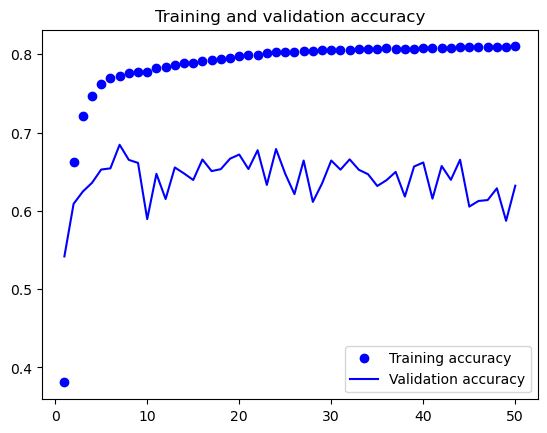

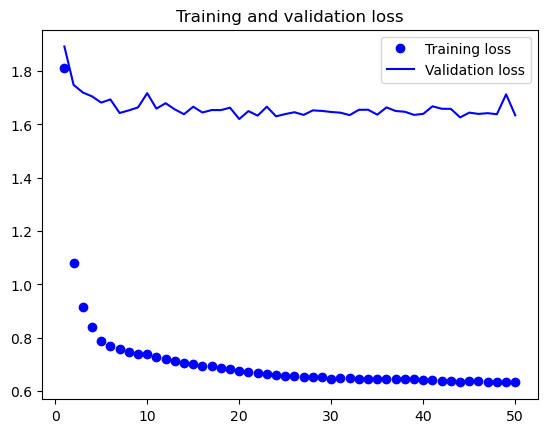

In [337]:
# Code taken from Deep Learning with Python, Second Edition Chapter 8 Listing 8.12

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()